<a href="https://colab.research.google.com/github/uyangas/Visualizations-in-Python/blob/main/Google_play_store_app_seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store App Data Visualization (Seaborn)

This Apps data scrapped from Google Play can be found https://www.kaggle.com/lava18/google-play-store-apps

The data contains 2 datasets.

`googleplaystore.csv` contains following columns.

- `index` - app index,
- `App` - app name, 
- `Category` - app category, 
- `Rating` - average rating, 
- `Reviews` - the number of reviews, 
- `Size` - the size of the app, 
- `Installs` - number of installs,
- `Type` - type of the app, 
- `Price` - price of the app ($), 
- `Content Rating` - content rating of the app, 
- `Genres` - app genre, 
- `Last Updated` - last updated date,
- `Current Ver` - current version, 
- `Android Ver` - android version

`googleplaystore_user_reviews.csv` contains following columns.

- `App` - name of the app, 
- `Translated_Review` - translated reviews, 
- `Sentiment` - review sentiment type, 
- `Sentiment_Polarity` - sentiment polarity,
- `Sentiment_Subjectivity` - sentiment subjectivity

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a80b0f3ee60ef05c5e98d0ef1c44376e51d680d885875545e5a1800383d8499e
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


## 1. Download the datasets

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle

In [3]:
# save kaggle.json to "kaggle" directory
! cp kaggle.json ~/.kaggle/

In [4]:
# change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download the dataset
! kaggle datasets download -d lava18/google-play-store-apps --force

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 63.0MB/s]


In [6]:
# create directory to unzip the data
! mkdir ~/.google_play_store

In [7]:
! unzip google-play-store-apps.zip -d google_play_store

Archive:  google-play-store-apps.zip
  inflating: google_play_store/googleplaystore.csv  
  inflating: google_play_store/googleplaystore_user_reviews.csv  
  inflating: google_play_store/license.txt  


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from wordcloud import WordCloud, ImageColorGenerator
import re

warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Data preprocessing

In [10]:
ps = pd.read_csv("google_play_store/googleplaystore.csv")
review = pd.read_csv("google_play_store/googleplaystore_user_reviews.csv")
ps.head()

App  ...   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ...  4.0.3 and up
1                                Coloring book moana  ...  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ...  4.0.3 and up
3                              Sketch - Draw & Paint  ...    4.2 and up
4              Pixel Draw - Number Art Coloring Book  ...    4.4 and up

[5 rows x 13 columns]

In [11]:
print(f"The size of the play store dataset: {ps.shape}, The size of the review dataset: {review.shape}")

The size of the play store dataset: (10841, 13), The size of the review dataset: (64295, 5)


In [12]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The imported data type of some of the variables such as `Price` and `Reviews` were objects. To perform calculations on some of the variables, `Price` was converted to numerical `float` value after `$` was removed, `Reviews` was converted to `int` and `Last Updated` was converted to `datetime` data type.

In [13]:
# a function that convert the datatypes of certain columns
def change_datatype(df):
  '''
  Fixes column problem of a data point and converts the columns to corresponding datatypes

  params: dataframe
  outcome: dataframe

  '''

  values = list(df.iloc[10472,:])
  values.insert(1, values.pop(12))
  df.iloc[10472,:] = values

  df['Price'] = df['Price'].str.strip('$').astype('float')
  df['Reviews'] = df['Reviews'].astype('int')

  df['Last Updated'] = pd.to_datetime(df['Last Updated'])

  return df

In [14]:
ps = change_datatype(ps)
ps.head()

App  ...   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ...  4.0.3 and up
1                                Coloring book moana  ...  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ...  4.0.3 and up
3                              Sketch - Draw & Paint  ...    4.2 and up
4              Pixel Draw - Number Art Coloring Book  ...    4.4 and up

[5 rows x 13 columns]

In the `ps` dataset, app names were duplicated. Total of 798 apps were duplicated. Some of the apps belonged to 2 categories or the number of reviews differed a bit. Therefore, to remove the duplicated values, the first values of each duplicated app was taken.

In [15]:
# Determine number of duplicated apps in the dataset using the app name
duplicated = ps[['App','Category']].groupby('App').count().sort_values(ascending=False, by='Category').reset_index().rename({"Category":"Number of duplications"},axis=1)
duplicated[duplicated['Number of duplications']>1].head()

App  Number of duplications
0                                             ROBLOX                       9
1  CBS Sports App - Scores, News, Stats & Watch Live                       8
2                     Duolingo: Learn Languages Free                       7
3                                               ESPN                       7
4                                        8 Ball Pool                       7

In [16]:
# Get the list of duplicated app names
df = pd.DataFrame()
for row in duplicated[duplicated['Number of duplications']>1]['App'].values:
  df = pd.concat([df, ps[ps['App'] == row].iloc[0,:]], axis=1)

In [17]:
# Remove duplicated values
df = df.T
ps = ps.loc[[True if row not in duplicated[duplicated['Number of duplications']>1]['App'].values else False for row in ps['App']],:]
ps = pd.concat([ps, df], axis=0)
ps.reset_index(inplace=True)

del df, duplicated

`Rating` had 1463 `NA` values which were not removed. `NA` values were ignored in the calculations.

In [18]:
ps.isna().sum()

index                0
App                  0
Category             1
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               1
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [19]:
ps = ps[~ps.Rating.isna()].astype({'Rating':'float'})

In [20]:
# Convert size to numerical value and express it in Megabyte.
ps['Size'] = [float(i.strip('k'))/1024 if i.find('k') > 0 else i.strip('M') for i in ps.Size]
ps['Size'] = ps['Size'].replace('Varies with device',0).astype('float')

In [21]:
# Calculate review percentage: percentage of people reviewed out of number of people installed
ps['review_perc'] = ps['Reviews']/ ps['Installs'].str.replace('+',"").str.replace(',',"").astype('int')

`review` dataset contains the review text and the sentiments of the reviews. 

In [22]:
review.head()

App  ... Sentiment_Subjectivity
0  10 Best Foods for You  ...               0.533333
1  10 Best Foods for You  ...               0.288462
2  10 Best Foods for You  ...                    NaN
3  10 Best Foods for You  ...               0.875000
4  10 Best Foods for You  ...               0.300000

[5 rows x 5 columns]

`review` dataset contains rows with many `NA` values. 41.7% of the rows didn't have any values. These rows were dropped.

In [23]:
review.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [24]:
review.dropna(inplace=True)
print(f"Shape of review dataset after NAs dropped: {review.shape}")

Shape of review dataset after NAs dropped: (37427, 5)


The number of apps in `review` dataset is less than that was in `ps` dataset. 1020 apps had reviews.

In [25]:
print(f"Total number of apps: {len(ps['App'].unique())}")
print(f"Number of apps with reviews: {len(review['App'].unique())}")
print(f"Number of apps with reviews available: {len(np.intersect1d(review['App'].unique(), ps['App'].unique()))}")

Total number of apps: 8197
Number of apps with reviews: 865
Number of apps with reviews available: 816


## 3. Exploratory Data Analysis

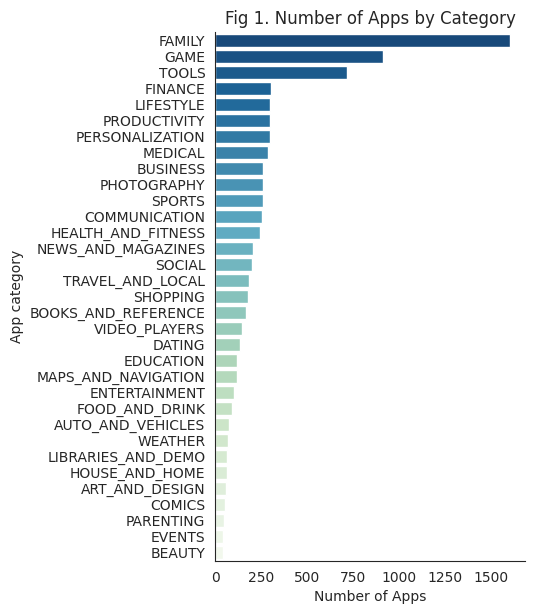

In [26]:
# Number of apps in each Category
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,7), dpi=100)
# Plot the number of apps in each category as bar plot
ax = sns.countplot(y='Category', data=ps[['Category','Type']],  
            order=ps[['Category','Type']].groupby('Category').count().sort_values(by='Type',ascending=False).index,
            palette='GnBu_r')

ax.set_title("Fig 1. Number of Apps by Category")
ax.set_xlabel("Number of Apps")
ax.set_ylabel("App category")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [61]:
ps.Category.value_counts()

FAMILY                 1608
GAME                    912
TOOLS                   718
FINANCE                 302
LIFESTYLE               301
PRODUCTIVITY            301
PERSONALIZATION         298
MEDICAL                 290
BUSINESS                263
PHOTOGRAPHY             263
SPORTS                  260
COMMUNICATION           256
HEALTH_AND_FITNESS      244
NEWS_AND_MAGAZINES      204
SOCIAL                  203
TRAVEL_AND_LOCAL        187
SHOPPING                180
BOOKS_AND_REFERENCE     169
VIDEO_PLAYERS           148
DATING                  134
MAPS_AND_NAVIGATION     118
EDUCATION               118
ENTERTAINMENT           102
FOOD_AND_DRINK           94
AUTO_AND_VEHICLES        73
WEATHER                  72
LIBRARIES_AND_DEMO       64
HOUSE_AND_HOME           62
ART_AND_DESIGN           61
COMICS                   54
PARENTING                50
EVENTS                   45
BEAUTY                   42
Name: Category, dtype: int64

`Family` has the highest number apps - 1608 apps and followed by `Game` - 912 and `Tools` - 718 apps. The lowest number of apps is `Beauty` - 42, `Events` - 45 and `Parenting` - 50 apps in the dataset.

Text(0.5, 1.05, 'Fig 2. Number of Apps by Content Rating')

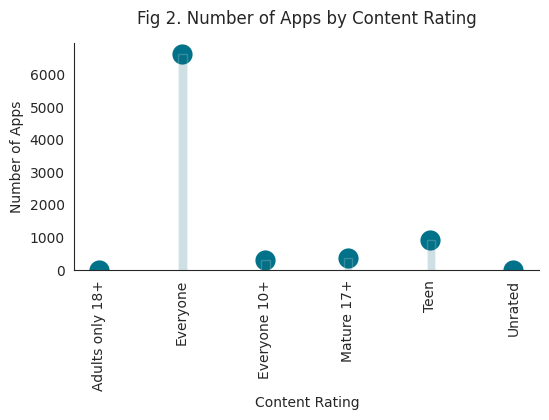

In [27]:
# Count number of apps by Content rating
cont_rating = ps.groupby('Content Rating').agg({'App':'count'}).reset_index()

fig, ax = plt.subplots(figsize=(6,3), dpi=100)
# Plot the number of apps of each content rating
sns.barplot(x=cont_rating['Content Rating'], 
            y= cont_rating['App'], 
            ax=ax, 
            color='#017289', 
            alpha=0.2, 
            edgecolor=None)
# Adjust the width of the bars
for bar in ax.patches:
  x = bar.get_x()
  width = bar.get_width()
  centre = x+width/2.
  bar.set_x(centre-width/20.)
  bar.set_width(0.1)
# Plot the bubbles 
sns.scatterplot(x=cont_rating['Content Rating'], y= cont_rating['App'], ax=ax, s=250, color='#017289')

ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Number of Apps")
ax.set_title("Fig 2. Number of Apps by Content Rating", y=1.05)

The majority of the apps are designed for people of all ages and there are very few apps for `Adults only 18+` and `Mature 17+`.

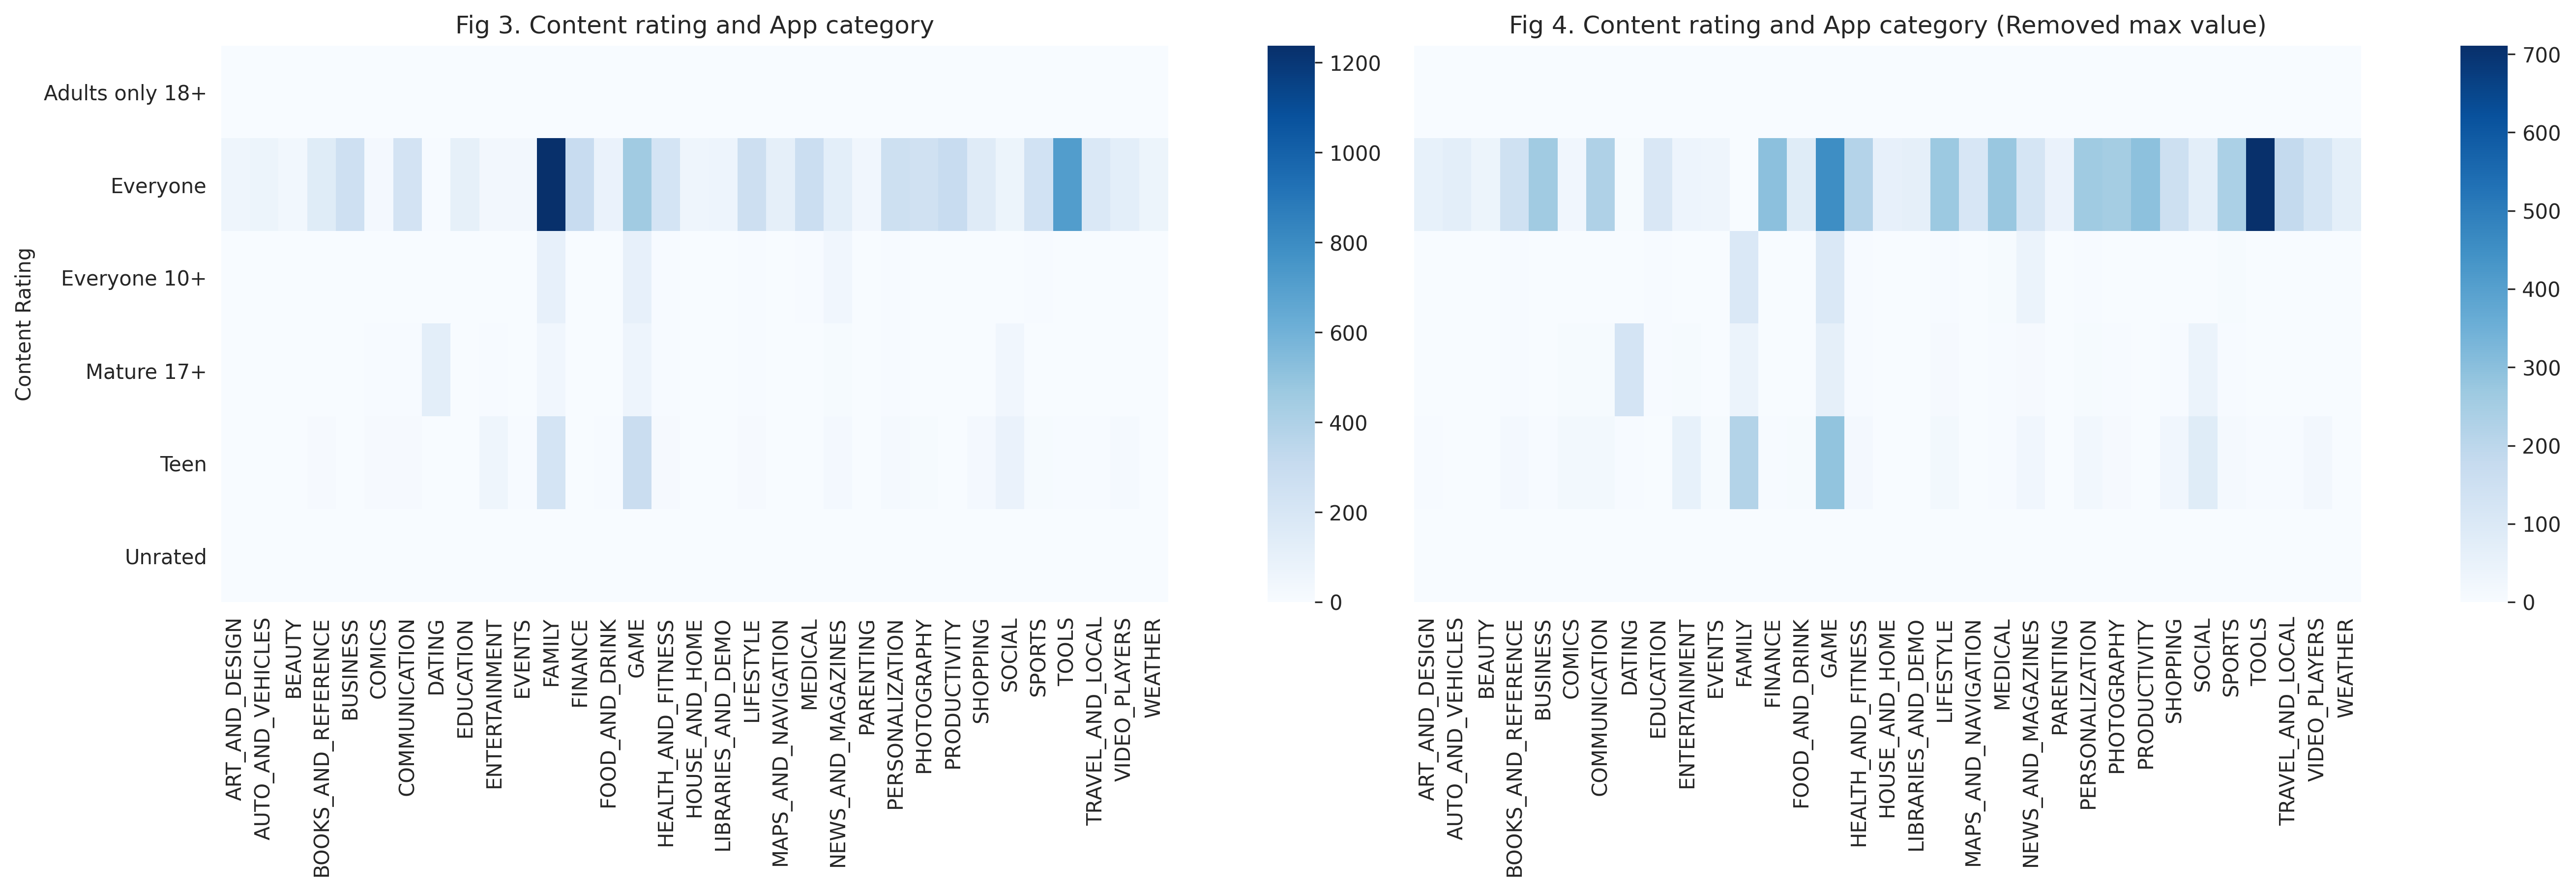

In [28]:
# Count the number of apps by Category and Content rating and pivot it to wide dataframe
app_cnt = ps.groupby(['Category', 'Content Rating']).agg({'App':'count'}).reset_index().pivot('Content Rating','Category','App').fillna(0)

f,(ax1, ax1cb, ax2, ax2cb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,0.05,1,0.05]},
            figsize=(20,5),
            dpi=300)
ax1.get_shared_y_axes().join(ax2)
# Plot the heatmap of the original values
g1 = sns.heatmap(app_cnt, ax=ax1, cbar_ax=ax1cb, cmap='Blues')
# Everyone and Family value was the highest and appeared the rest of the values insignificant
app_cnt.loc['Everyone', 'FAMILY'] = 0
# Plot the heatmap of the value removed
g2 = sns.heatmap(app_cnt, ax=ax2, cbar_ax=ax2cb, cmap='Blues')

g2.set_yticklabels("")
g1.set_xlabel("")
g2.set_xlabel("")
g2.set_ylabel("")
g2.set_yticks([])
g1.set_title("Fig 3. Content rating and App category")
g2.set_title("Fig 4. Content rating and App category (Removed max value)")

# Adjust the tick labels
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

Despite the fact that the most apps are developed for people of all ages, if we look at the `Category` and `Content Rating` cross heatmap, we can see that `entertainment`, `family`, `gaming` and `social` apps mostly developed for `teens`.

Text(0.5, 1.0, 'Fig 5. Percentage of Paid Apps')

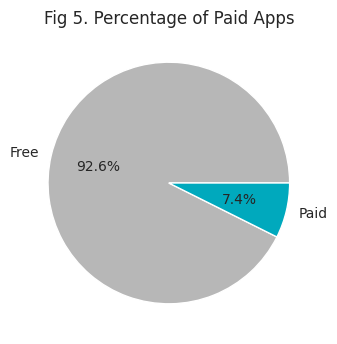

In [57]:
fig, ax = plt.subplots(dpi=100)
# Plot the percentage of paid apps as a pie chart
ax.pie(dict(ps['Type'].value_counts()).values(), 
       labels =dict(ps['Type'].value_counts()).keys(), 
       autopct='%1.1f%%', 
       colors=['#B7B7B7','#00A9BD'])

ax.set_title("Fig 5. Percentage of Paid Apps")

92.2% of all the apps are free and only 7.8% are paid apps. 

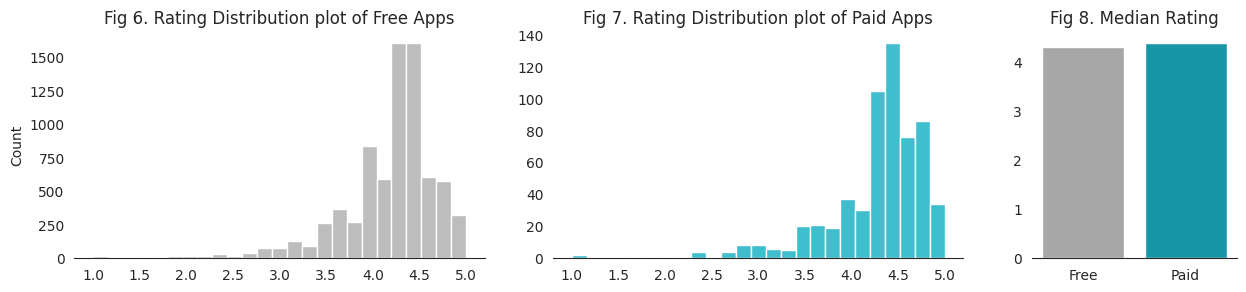

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, 
                                    figsize=(15,3),
                                    gridspec_kw={'width_ratios':[2,2,1]},
                                    dpi=100)
# Plot the Rating distribution of Free apps
sns.histplot(x='Rating', data=ps[ps['Type'] == 'Free'], 
             ax=ax1, 
             color='#A7A7A7',
             bins=25)
# Plot the Rating distribution of Paid apps
sns.histplot(x='Rating', data=ps[ps['Type'] == 'Paid'], 
             ax=ax2, 
             color='#00A9BD',
             bins=25)
# Plot the median Rating of Free and Paid apps
sns.barplot(x='Type', y='Rating', data=ps, 
                ci=False, estimator=np.median,
            ax=ax3,
            palette=['#A7A7A7','#00A9BD'])

ax1.set_title("Fig 6. Rating Distribution plot of Free Apps")
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.set_title("Fig 7. Rating Distribution plot of Paid Apps")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.set_title("Fig 8. Median Rating")
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

If we look at the `Rating` of free and paid apps, they both have similar median ratings, free apps - 4.3 and paid apps - 4.4. Since the distributions of rating are left skewed, therefore, the median was used from here on after when comparisons were made.

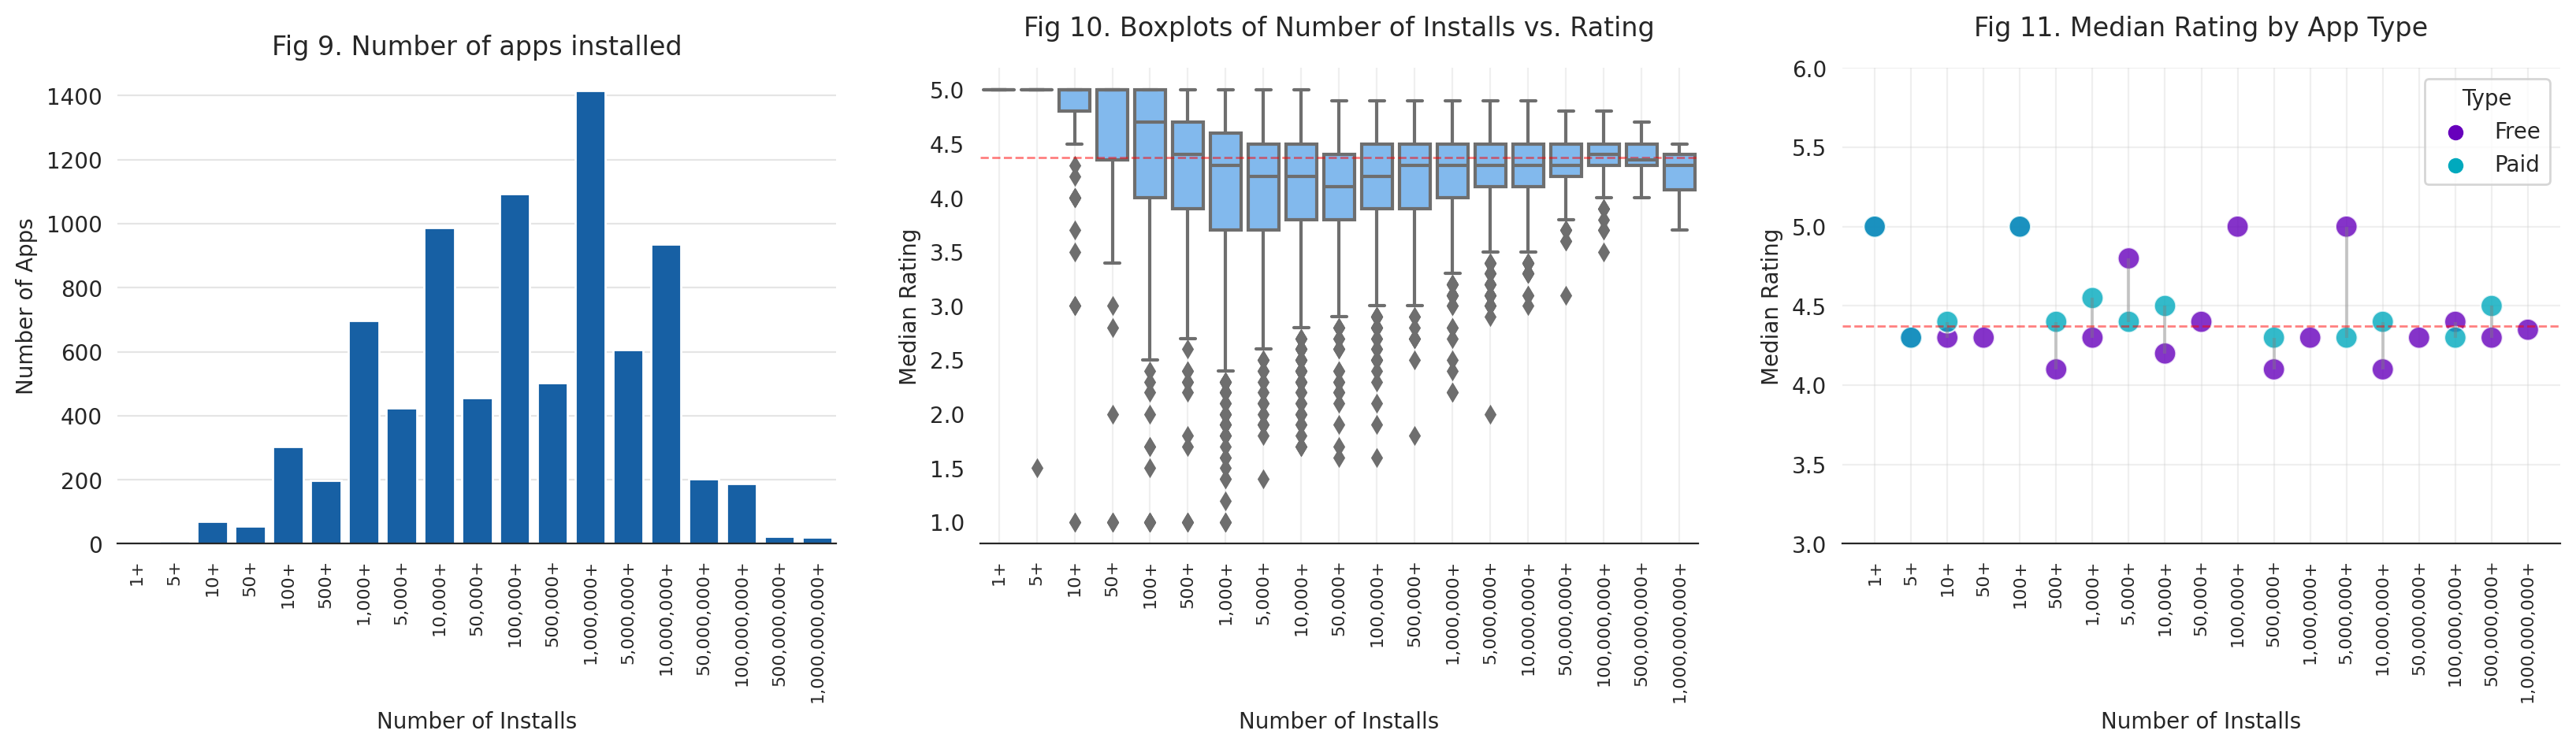

In [32]:
order_app = ['1+', '5+','10+','50+','100+', '500+','1,000+','5,000+',
             '10,000+','50,000+','100,000+','500,000+','1,000,000+','5,000,000+',
             '10,000,000+', '50,000,000+', '100,000,000+','500,000,000+', '1,000,000,000+']

# Median ratings by Installs and Type
installs = ps.groupby(['Installs','Type']).agg({'Rating':'median'}).reset_index()
# Maximum Rating by Installs
installs_diff = installs.groupby('Installs').agg({'Rating':'max'})
# Minimum Rating by Installs
installs_diff['min'] = installs.groupby('Installs').agg({'Rating':'min'}).Rating

fig, (ax1, ax0, ax) = plt.subplots(1,3, figsize=(20,4), dpi=200)
# Plot bubble scatterplot of Rating by Installs
sns.scatterplot(x='Installs',
                y='Rating',
                data =installs,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=100,
                alpha=0.8,
                ax=ax)
# Add vertical lines between the bubbles
ax.vlines(x=installs_diff.index, 
          ymin=installs_diff['min'], 
          ymax=installs_diff['Rating'], 
          color='grey', 
          alpha=0.4)
# Add the median rating to the bubble scatterplot
ax.axhline(installs.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(order_app,rotation=90, fontsize=8)
ax.set_xlabel("Number of Installs")
ax.set_ylabel("Median Rating")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Fig 11. Median Rating by App Type", y=1.04)
ax.yaxis.grid(True, alpha=0.3)
ax.xaxis.grid(True, alpha=0.3)

# Plot the boxplot of Rating by Installs
sns.boxplot(x='Installs', 
            y='Rating', 
            data=ps, 
            ax=ax0, 
            order=order_app,
            color='#70BAFF')

ax0.set_xticklabels(order_app, rotation=90, fontsize=8)
ax0.set_xlabel("Number of Installs")
ax0.set_ylabel("Median Rating")
ax0.set_title("Fig 10. Boxplots of Number of Installs vs. Rating", y=1.04)
ax0.axhline(installs.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)
ax0.xaxis.grid(True, alpha=.3)
ax0.spines['top'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['right'].set_visible(False)

# Plot the bar chart of Number of apps in each Installs category
sns.countplot('Installs', data=ps, ax=ax1, order=order_app, color='#0061BB')

ax1.set_xticklabels(order_app, rotation=90, fontsize=8)
ax1.set_title('Fig 9. Number of apps installed')
ax1.set_xlabel("Number of Installs")
ax1.set_ylabel('Number of Apps')
ax1.yaxis.grid(True, alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

Apps with very few installs, less than 1000, tend to have greater than overall median rating which could be due to few number of reviews and rating and possibly that the ratings were giving not by the actual target users. The range of the highest and the lowest ratings were the greatest for these apps.

Median app ratings went down between 1000 and 100,000 installs. This suggests that the apps starts to get recognition as the number of users who review the apps increases. During this stage, the apps usually update, fix and create features and contents to gain more users. The gap between the highest and the lowest ratings were closer compared to the apps with very few installs.

As for apps with over 500,000 installs, the median ratings went to up and ultimately reached the overall median level. The gap between the highest and the lowest ratings got smaller. This suggests that the mode installs the app has, the more stable it becomes which means less bad review and ratings.  

As the number of installs grows, meaning as the app becomes popular, the rating gap between free and paid apps gets smaller. For apps that have less than 10,000 installs, the gap between free and paid is greater than those apps with higher number of installs. This suggests that as the app gets popular, so does the quality of the programs and contents.

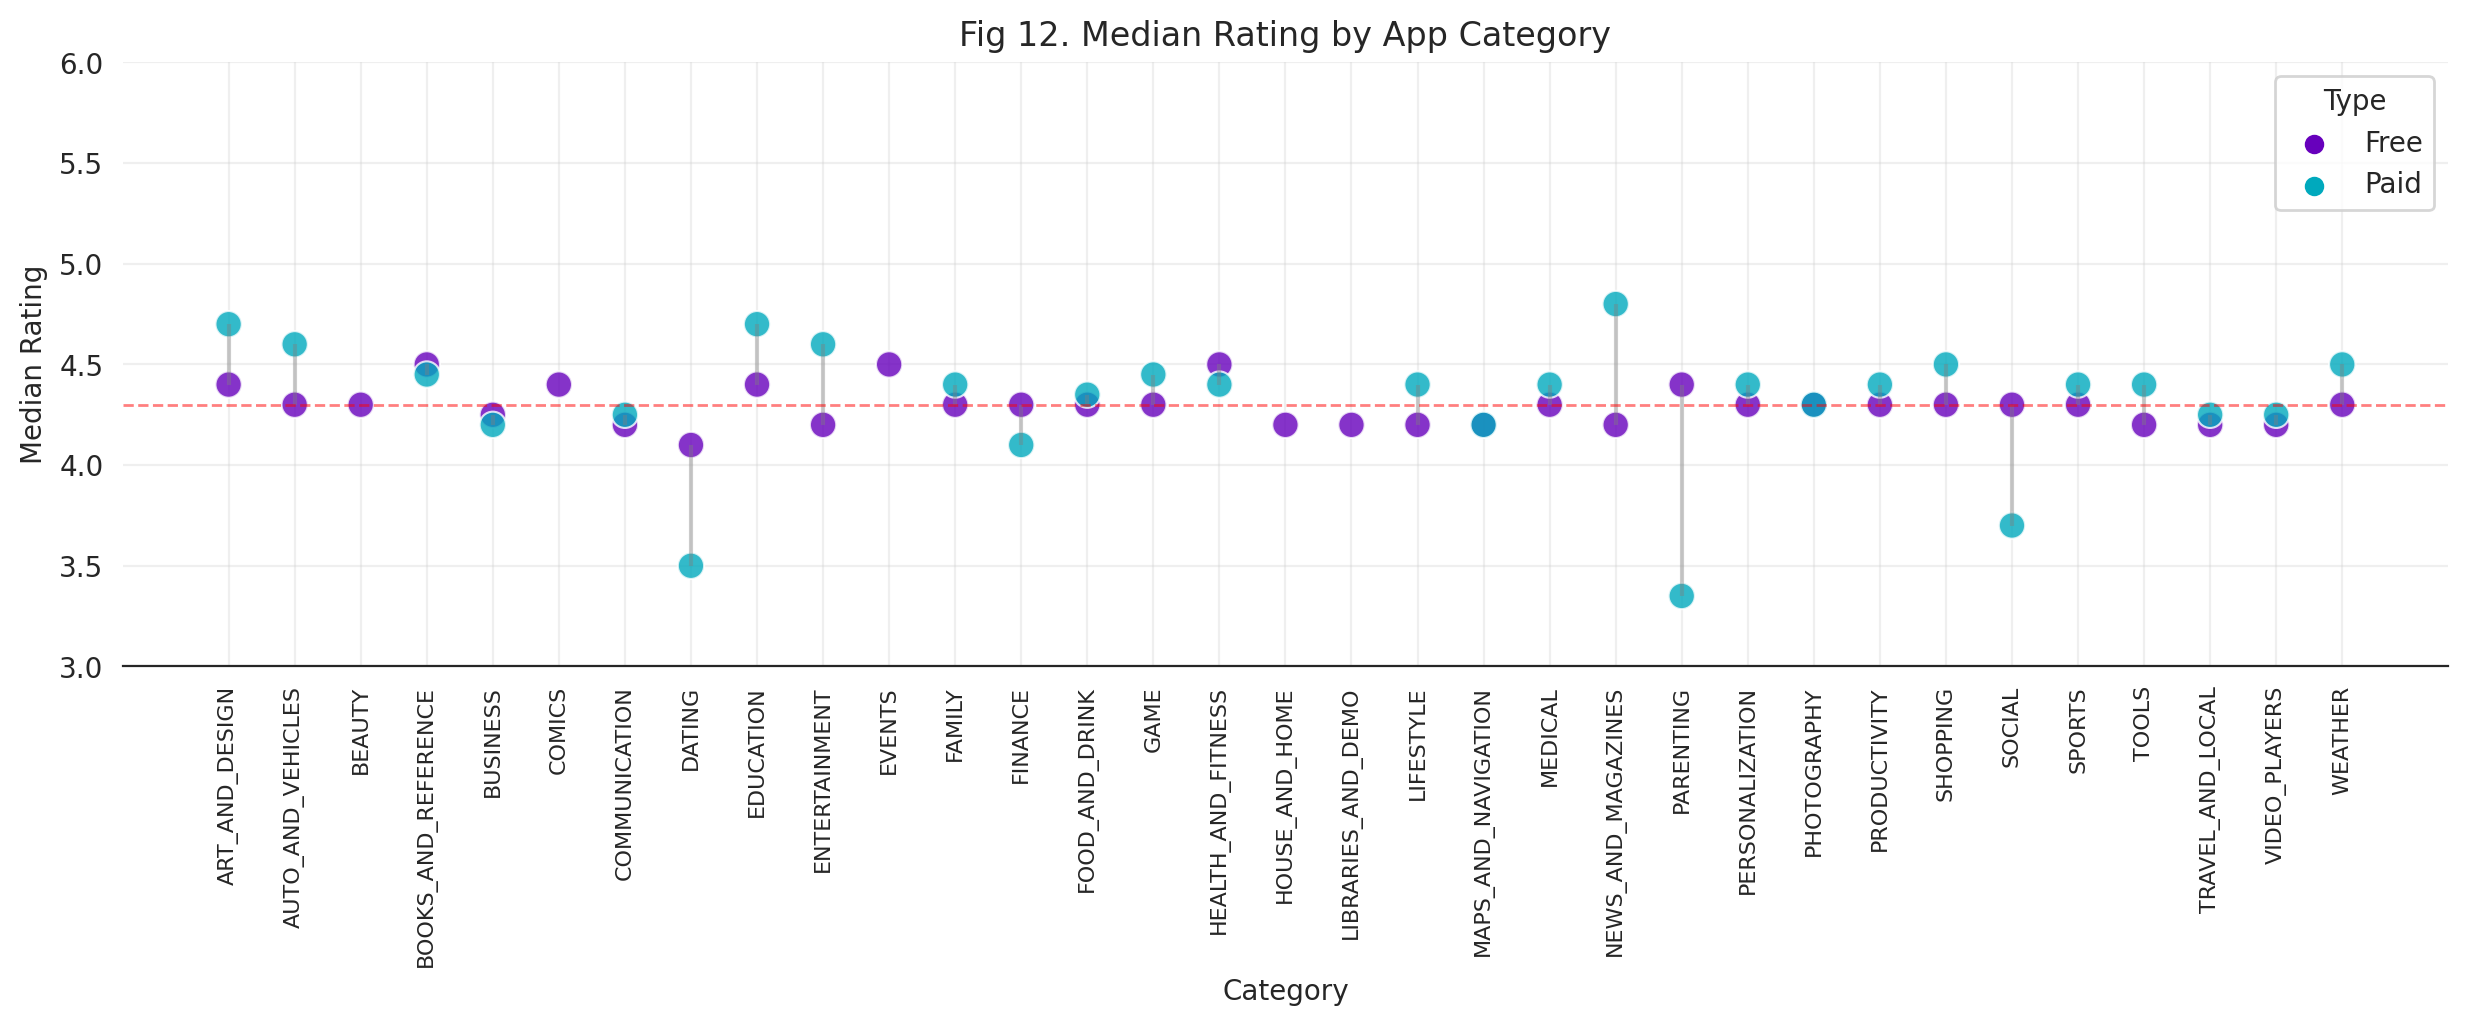

In [33]:
# Median rating by Category and Type
cat_rating = ps.groupby(['Category','Type']).agg({'Rating':'median'}).reset_index()
# Maximum rating by Category
cat_rating_diff = cat_rating.groupby('Category').agg({'Rating':'max'})
# Minimum rating by Category
cat_rating_diff['min'] = cat_rating.groupby('Category').agg({'Rating':'min'}).Rating

fig, ax = plt.subplots(figsize=(15,4), dpi=200)
# Plot the bubbles
sns.scatterplot(x='Category',
                y='Rating',
                data =cat_rating,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=90,
                alpha=0.8,
                ax=ax)
# Add the vertical lines between the bubbles
ax.vlines(x=cat_rating_diff.index, 
          ymin=cat_rating_diff['min'], 
          ymax=cat_rating_diff['Rating'], 
          color='grey', 
          alpha=0.4)
# Add median horizontal line to the bubble chart
ax.axhline(cat_rating.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(cat_rating_diff.index, rotation=90, fontsize=8)
ax.set_xlabel("Category")
ax.set_ylabel("Median Rating")
ax.set_title("Fig 12. Median Rating by App Category")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, alpha=.3)
ax.xaxis.grid(True, alpha=.3)

`Beauty`, `Comics`, `House and home` and `Libraries and demo` categories didn't have any paid apps i.e. apps in these categories are free.

`Dating`, `Finance`, `Parenting` and `Social` categories have lower median rating for paid apps compared to the free ones. For these types of apps, users seems to put more expectations for the paid version.

`Business`, `Communication`, `Maps and navigation`, `Travel and local` and `Video Players` categories have median app rating below overall median rating for both paid and free apps.

Other categories have above overal median rating ratings and paid apps tend to have higher rating compared to the free ones. 

Text(0.5, 0.98, 'Fig 13. App Size vs. Rating')

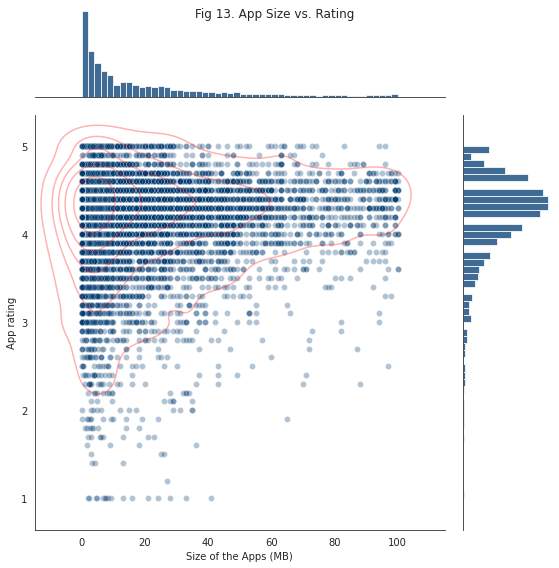

In [34]:
# Plot the jointplot of Rating and App size
g = sns.jointplot('Size', 
              'Rating', 
              data=ps, 
              alpha=.3, 
              kind='scatter',
              color='#003A71',
              marginal_kws=dict(rug=True, bins=50),
              height=8, ratio=4)

g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6, alpha=0.3)
g.set_axis_labels(xlabel="Size of the Apps (MB)",
                  ylabel='App rating')
g.fig.suptitle("Fig 13. App Size vs. Rating")

The most apps have a size of less than 10MB. App size doesn't directly correlate with the App rating. Let's see app size difference by app category.

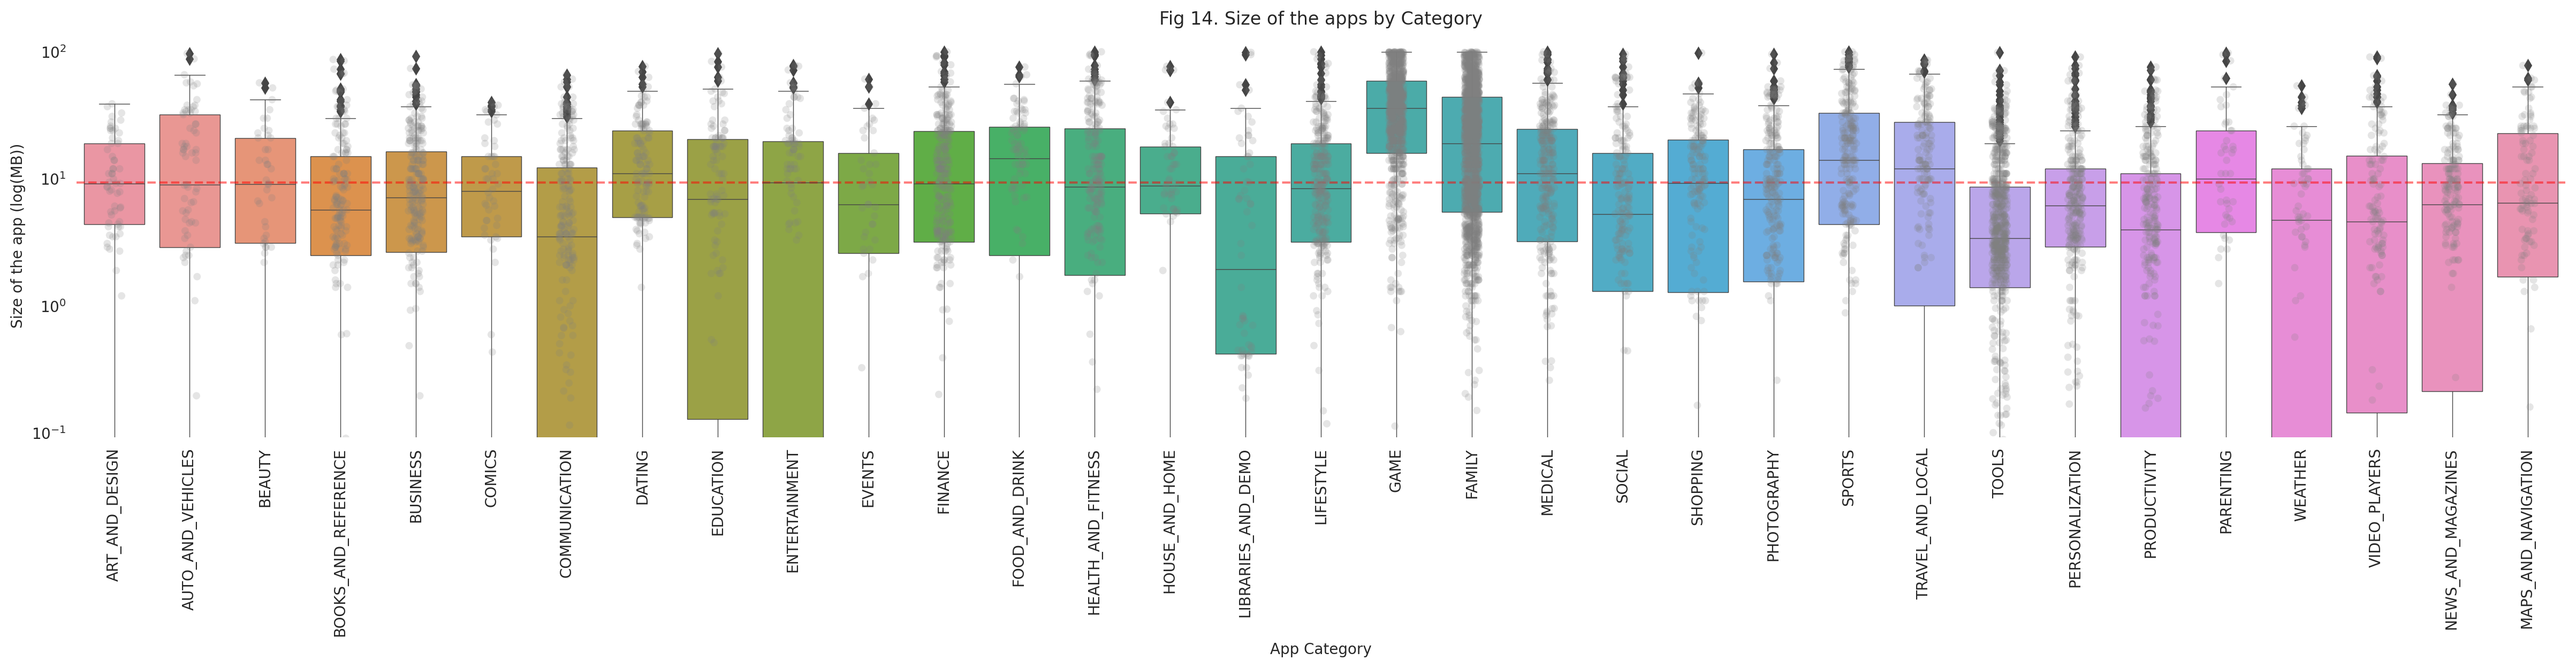

In [56]:
fig, ax = plt.subplots(figsize=(30,5), dpi=200)
# Plot boxplot of app size by each category
ax = sns.boxplot(x='Category', y='Size', data=ps, linewidth=0.5)
# Plot each value of size on the boxplot
ax = sns.stripplot('Category', 'Size', data=ps, alpha=0.2, color='grey')
# Add horizontal line of Median app size
ax.axhline(ps.Size.median(), color='red', linestyle='--', alpha=0.5)

ax.set_xticklabels(ps.Category.unique(), rotation=90)
ax.set_title("Fig 14. Size of the apps by Category")
ax.set_ylabel("Size of the app (log(MB))")
ax.set_xlabel("App Category")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yscale('log')

`Communication`, `Education`, `Entertainment`, `Productivity`, `Weather`, `Video Player`, `News and magazine` apps have smaller size compared to the other types of apps. `Dating`, `Game`, `Family`, `Sports` apps have overall bigger app sizes compared to the other types of apps.

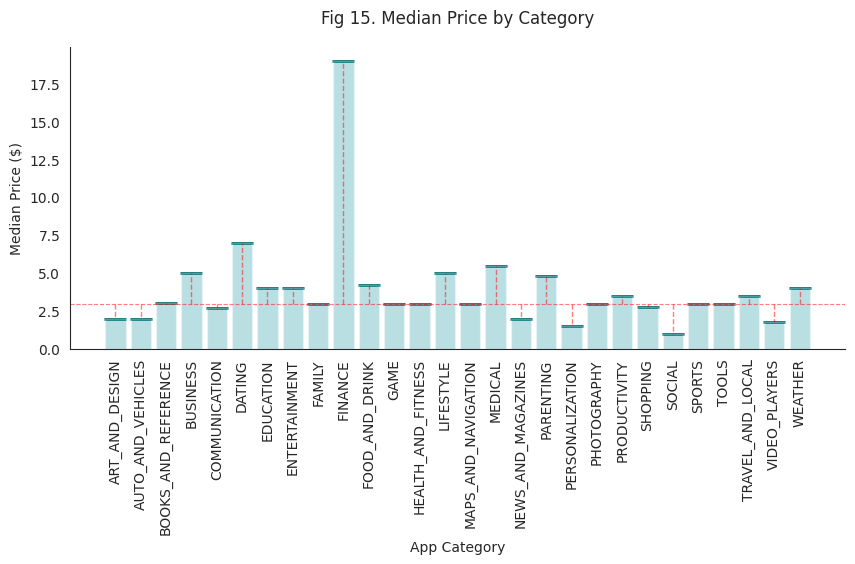

In [36]:
# Convert price to float
ps['Price'] = ps['Price'].astype('float')
# Median price by Category
price_median = ps[ps.Price>0].groupby(['Category']).agg({'Price':'median'}).reset_index()

fig, ax = plt.subplots(figsize=(10,4), dpi=100)
# Plot a Line of Median price of each Category
sns.scatterplot(x='Category', 
            y='Price', 
            data=price_median,  
            marker= '_',
            s=240,
            color='#006A6A',
            ax=ax,
            linewidth=2)
# Add Median price horizontal line
ax.axhline(price_median.Price[price_median.Price > 0].median(), color='red', linestyle='--', alpha=0.5, linewidth=0.8)
# Plot a Bar of Median Price of each category
sns.barplot(x='Category', 
            y='Price', 
            data=price_median,  
            ax=ax,
            alpha=0.3,
            color='#00A9BD')
# Add vertical lines greater and lower than the overall median price
ax.vlines(x=price_median.Price[price_median.Price > 0].index,
          ymin=price_median.Price[price_median.Price > 0].median(),
          ymax=price_median.Price,
          color='red', 
          linestyle='--', 
          alpha=0.5, 
          linewidth=1)

ax.set_xticklabels(price_median.Category.unique(), rotation=90)
ax.set_title("Fig 15. Median Price by Category", y=1.05)
ax.set_ylabel("Median Price ($)")
ax.set_xlabel("App Category")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

Overal median price of the apps is `$2.99`. Now, if we look at the prices of paid apps, `Finance` apps have the highest median price `$18.99` followed by `Business` - `$4.99`, `Dating` - `$6.99`, `Lifestyle` - `$4.99`, `Medical` - `$4.59`, `Parenting` - `$4.79`, `Food and Drink` - `$4.24`. 

`Comic`, `Beauty`, `Events`, `House and Home`, and `Libraries and Demo` apps have no price i.e. free to use.

Below table is the apps with the highest prices.

In [37]:
# Create a dictionary with app: price of the apps with the highest price
price_max = {row[1].Category:row[1].Price for row in ps.groupby(['Category']).agg({'Price':'max'}).reset_index().iterrows()}
# Create boolean value of the apps with the highest prices in `price_max` dictionary
app_max_price = []
for row in ps.iterrows():
  row_values = row[1]

  try:
    if row_values.Price == price_max[row_values.Category]:
      app_max_price.append(True)
    else:
      app_max_price.append(False)
      
  except KeyError:
    app_max_price.append(True)
# Filter the dataframe using the boolean value
highest_price = ps[app_max_price]
highest_price[highest_price.Price >0][['App','Category','Price','Installs']].sort_values(by='Category')

App  ...  Installs
3036     X Launcher Prime: With OS Style Theme & No Ads  ...    1,000+
3031  X Launcher Pro - IOS Style Theme & Control Center  ...   10,000+
3027  X Launcher Pro: PhoneX Theme, OS11 Control Center  ...    5,000+
2546                             Ulysse Speedometer Pro  ...   50,000+
7010                      Officiel du SCRABBLE LAROUSSE  ...    5,000+
5008                                 SkyTest BU/GU Lite  ...      500+
6137                        Morse Decoder for Ham Radio  ...    5,000+
3334                       AG Contacts, Premium edition  ...      500+
2598                           K-@ Mail Pro - Email App  ...   10,000+
315   AMBW Dating App: Asian Men Black Women Interra...  ...      100+
9460             Fuzzy Numbers: Pre-K Number Foundation  ...    1,000+
558                                      My Talking Pet  ...  100,000+
2529                             most expensive app (H)  ...      100+
3608                                      I Am Rich Pro  ...    5,000+
3600                                     I am Rich Plus  ...   10,000+
3615                                          I am Rich  ...    5,000+
3619                                 I AM RICH PRO PLUS  ...    1,000+
3610                     I am rich (Most expensive app)  ...    1,000+
3605                                 I am rich(premium)  ...    5,000+
3604                                         I am Rich!  ...    1,000+
3602                                  I Am Rich Premium  ...   50,000+
749                              Paprika Recipe Manager  ...   50,000+
2534                            The World Ends With You  ...   10,000+
8782                                    Fast Tract Diet  ...    1,000+
2671                           I'm Rich - Trump Edition  ...   10,000+
4203                 BackCountry Navigator TOPO GPS PRO  ...  100,000+
9134                          Vargo Anesthesia Mega App  ...    1,000+
7885                          Égalité et Réconciliation  ...      500+
4183                        Baby Connect (activity log)  ...   50,000+
1983                                       BIG Launcher  ...   10,000+
3291                                         NewTek NDI  ...    1,000+
6339    ACCDB MDB DB Manager Pro - Editor for MS Access  ...      500+
6479                                       Penny Finder  ...   10,000+
2999                               W-History Standalone  ...    1,000+
3230                            WhatsFake Pro (Ad free)  ...    5,000+
1706                            Golfshot Plus: Golf GPS  ...   50,000+
2506                                     G-NetTrack Pro  ...    5,000+
7302                         Electrician Calculator Pro  ...    1,000+
2445                      Maps & GPS Navigation OsmAnd+  ...  100,000+
4893                                           BSPlayer  ...   50,000+
8611                            Florida Tides & Weather  ...    1,000+

[41 rows x 4 columns]

In [38]:
# Calculate number of reviews per app and review sentiment
app_review = review.groupby(['App','Sentiment']).agg({'Translated_Review':'count'})\
.reset_index()\
.rename({'Translated_Review':'Number_Sentiment'},axis=1)\
.pivot('App','Sentiment','Number_Sentiment').fillna(0)

In [39]:
positive_perc = []
negative_perc = []
neutral_perc = []

# Create percentage of positive, negative, and neutral reviews in total number of reviews for each app
for row in app_review.iterrows():
  row_values = row[1]
  positive_perc.append(row_values['Positive']/sum(row_values[['Negative','Neutral','Positive']]))
  negative_perc.append(row_values['Negative']/sum(row_values[['Negative','Neutral','Positive']]))
  neutral_perc.append(row_values['Neutral']/sum(row_values[['Negative','Neutral','Positive']]))

app_review['positive_perc'] = positive_perc
app_review['negative_perc'] = negative_perc
app_review['neutral_perc'] = neutral_perc
app_review.drop(['Negative',	'Neutral',	'Positive'], axis=1, inplace=True)

In [40]:
# Merge `ps` dataframe with `app_review` dataframe to get the percentage review columns
app_review = pd.merge(ps, app_review, on='App', how='left')

# Create categorical label for Rating
bins = [0, 3.0, 3.5, 4.0, 4.5, np.inf]
labels = ['1. <3.0', '2. 3.0-3.5', '3. 3.5-4.0', '4. 4.0-4.5', '5. 4.5-5.0']

app_review['Rating_Cat'] = pd.cut(app_review.Rating, bins, labels=labels)

In [41]:
# Create boolean variable that determines whether the app has any reviews
app_review['Sentiment_null'] = app_review.positive_perc.isna()
# Calculate Number of apps with reviews and percentage of apps with reviews by rating category
sent_num = app_review.groupby(['Rating_Cat']).agg({'Sentiment_null':'sum', 'Rating':'count'}).reset_index().assign(Sentiment = lambda x: 1-x.Sentiment_null/x.Rating).drop(['Sentiment_null',	'Rating'], axis=1)
# Calculate Number of apps with reviews and percentage of apps with reviews by app category
sent_cat = app_review.groupby(['Category']).agg({'Sentiment_null':'sum', 'Rating':'count'}).reset_index().assign(Sentiment = lambda x: 1-x.Sentiment_null/x.Rating).drop(['Sentiment_null',	'Rating'], axis=1)
# Calculate number of apps with and without reviews and create dictionary for the pie chart
total = {'No reviews': app_review.Sentiment_null.sum()/len(app_review.Sentiment_null), 'With reviews':1-app_review.Sentiment_null.sum()/len(app_review.Sentiment_null)}
# Drop NA values
app_review.dropna(inplace=True)
# Take mean of percentage of reviews by Rating category and App category
sent_num_perc = app_review.groupby(['Rating_Cat']).agg({'positive_perc':'mean',	'negative_perc':'mean',	'neutral_perc':'mean'}).reset_index()
sent_cat_perc = app_review.groupby(['Category']).agg({'positive_perc':'mean',	'negative_perc':'mean',	'neutral_perc':'mean'}).reset_index()

Text(0.5, 1.05, 'Rating Category')

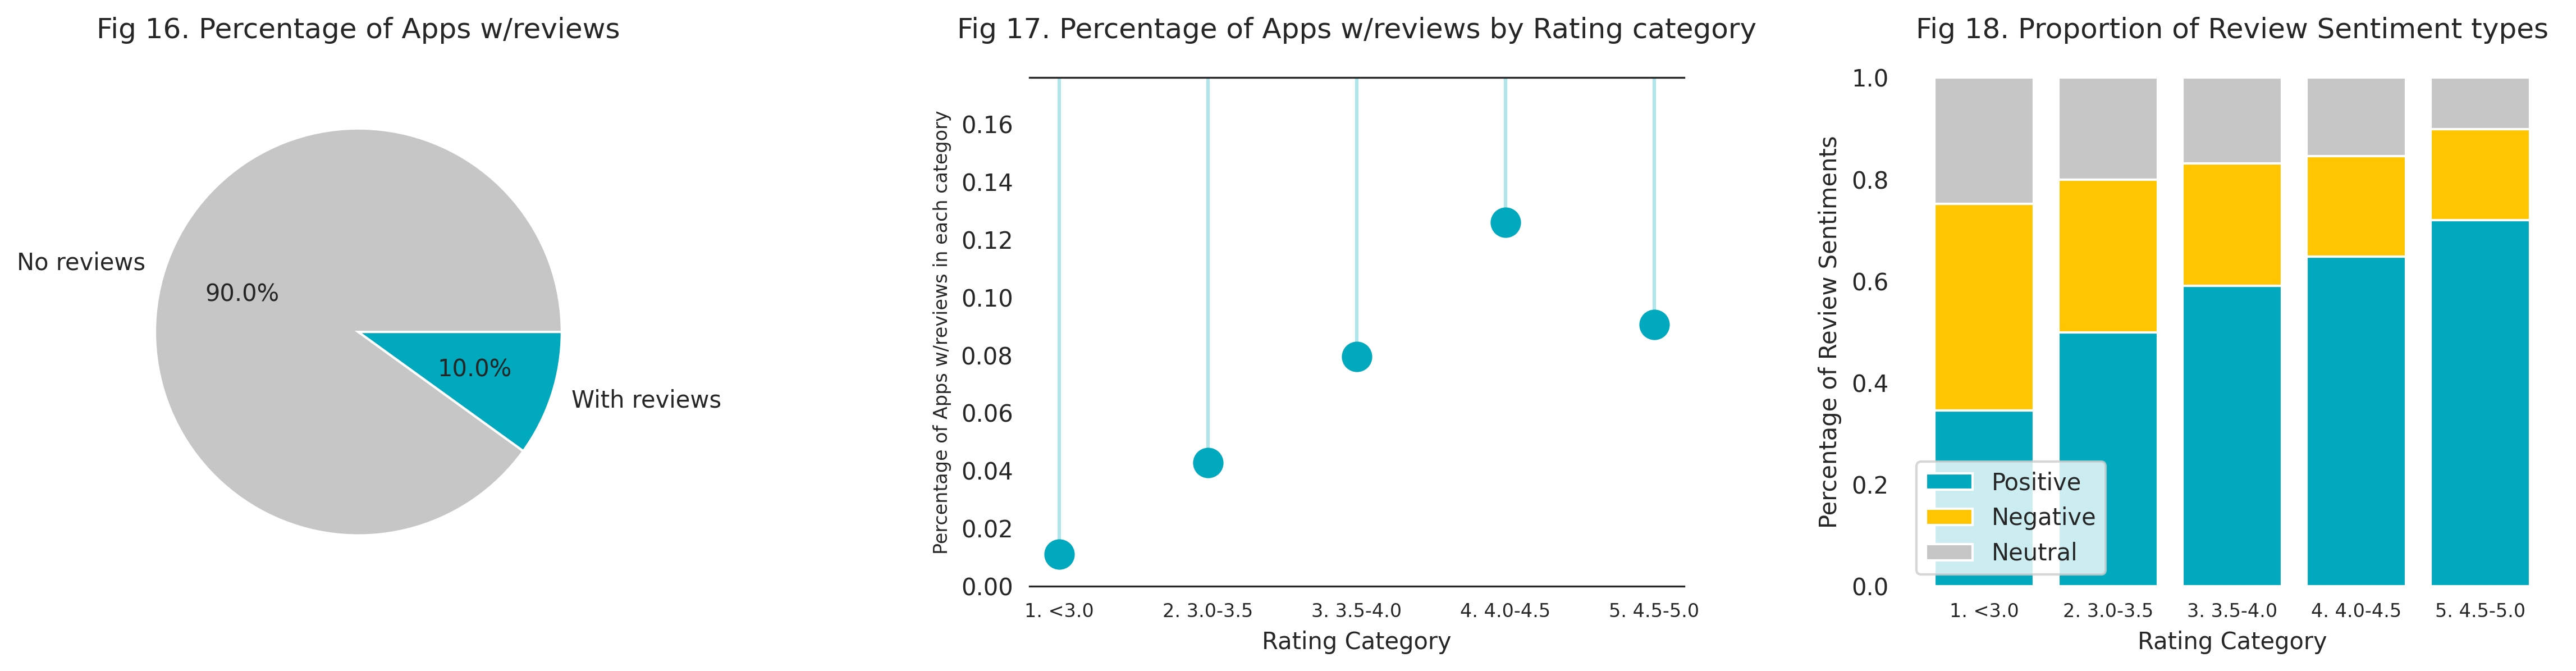

In [42]:
fig, (ax1, ax3,  ax2, ax5, ax4) = plt.subplots(1, 5, 
                               figsize=(20, 4),
                               gridspec_kw={'width_ratios':[1, 0.1, 0.8, 0.05, 0.8]},
                               dpi=300)
# Plor pie chart of number of apps with and without the reviews
ax1.pie(total.values(), labels=total.keys(),
        autopct='%1.1f%%', 
        colors=['#C6C6C6','#00A9BD'])
# Plot Number of apps with reviews by rating category -  bubble chart
sns.scatterplot(sent_num.Rating_Cat, 
                sent_num.Sentiment, 
                ax=ax2,
                color='#00A9BD',
                s=200,
                legend=False)
# Plot stems of the bubbles
ax2.vlines(x = sent_num.Rating_Cat, 
           ymin = sent_num.Sentiment,
           ymax = sent_num.Sentiment.max()+0.05,
           color='#00A9BD',
           alpha=0.3)
# Plot Stacked bar chart of review sentiments
ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.positive_perc,
        label='Positive',
        color='#00A9BD')
# Plot Stacked bar chart of review sentiments
ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.negative_perc,
        label='Negative',
        bottom=sent_num_perc.positive_perc,
        color='#FFC500')
# Plot Stacked bar chart of review sentiments
ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.neutral_perc,
        label='Neutral',
        bottom=sent_num_perc.positive_perc+sent_num_perc.negative_perc,
        color='#C6C6C6')

ax1.set_title("Fig 16. Percentage of Apps w/reviews", y=1.05)
ax2.set_title("Fig 17. Percentage of Apps w/reviews by Rating category", y=1.05)
ax2.set_xlabel("Rating Category", y=1.05)
ax2.set_ylabel("Percentage of Apps w/reviews in each category", fontsize=8)
ax2.set_xticklabels(sent_num.Rating_Cat, fontsize=8)
ax2.set_ylim(0, sent_num.Sentiment.max()+0.05)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax3.axis('off')
ax3.set_yticklabels([])
ax3.set_xticklabels([])

ax5.axis('off')
ax5.set_yticklabels([])
ax5.set_xticklabels([])

ax4.legend()
ax4.set_ylim(0,1)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_xticklabels(sent_num.Rating_Cat, fontsize=8)
ax4.set_title("Fig 18. Proportion of Review Sentiment types", y=1.05)
ax4.set_ylabel("Percentage of Review Sentiments")
ax4.set_xlabel("Rating Category", y=1.05)

Out of 8'197 apps, only 10% of them have reviews from the users. Apps with rating between 4.0 and 4.5 have the highest number of reviews. As the rating increases, average number of positive reviews increases and average number of negative reviews decreases. The higher the rating is, the higher the number of positive reviews.

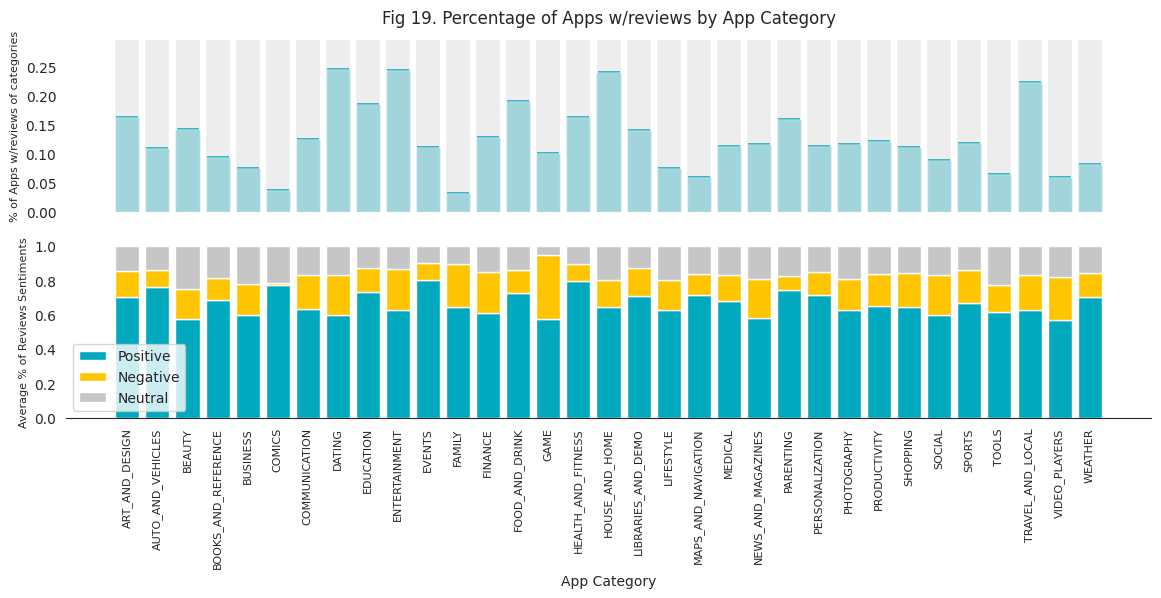

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize=(14, 5),
                               dpi=100)
# Plot number of apps with reviews by category - line chart
sns.scatterplot(sent_cat.Category, 
            sent_cat.Sentiment, 
            ax=ax1,
            marker="_",
            s=250,
            color='#00A9BD')
# Plot number of apps with reviews by category - bar chart
sns.barplot(sent_cat.Category, 
            sent_cat.Sentiment, 
            ax=ax1,
            color='#00A9BD',
            alpha=0.4)
# Plot number of apps with reviews by category - vertical line on top of the scatterplot
ax1.vlines(x = sent_cat.Category, 
           ymin = sent_cat.Sentiment,
           ymax = sent_cat.Sentiment.max()+0.05,
           color='#A7A7A7',
           alpha=0.2,
           linewidth=17)
# Plot stacked bar chart of number of review by category
ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.positive_perc,
        label='Positive',
        color='#00A9BD')
# Plot stacked bar chart of number of review by category
ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.negative_perc,
        label='Negative',
        bottom=sent_cat_perc.positive_perc,
        color='#FFC500')
# Plot stacked bar chart of number of review by category
ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.neutral_perc,
        label='Neutral',
        bottom=sent_cat_perc.positive_perc+sent_cat_perc.negative_perc,
        color='#C6C6C6')

ax1.set_xticklabels([])
ax1.set_title("Fig 19. Percentage of Apps w/reviews by App Category", y=1.05)
ax1.set_ylim(0, sent_cat.Sentiment.max()+0.05)
ax1.set_ylabel("% of Apps w/reviews of categories", fontsize=8)
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.set_xticklabels(sent_cat_perc.Category, rotation=90, fontsize=8)
ax2.set_ylim(0, 1)
ax2.set_xlabel("App Category")
ax2.set_ylabel("Average % of Reviews Sentiments", fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend()
ax2.grid(axis='x')

`Dating`, `Entertainment`, `House and Home`, `Travel and Local`, `Education`, `Food and Drink` apps tend to have the higher reviews. As for review sentiments, `Comics`, `Events`, `Health and Fitness`, `Parenting`, `Auto and Vehicle` apps have the highest positive reviews. `Game` app have the highest negative reviews. 

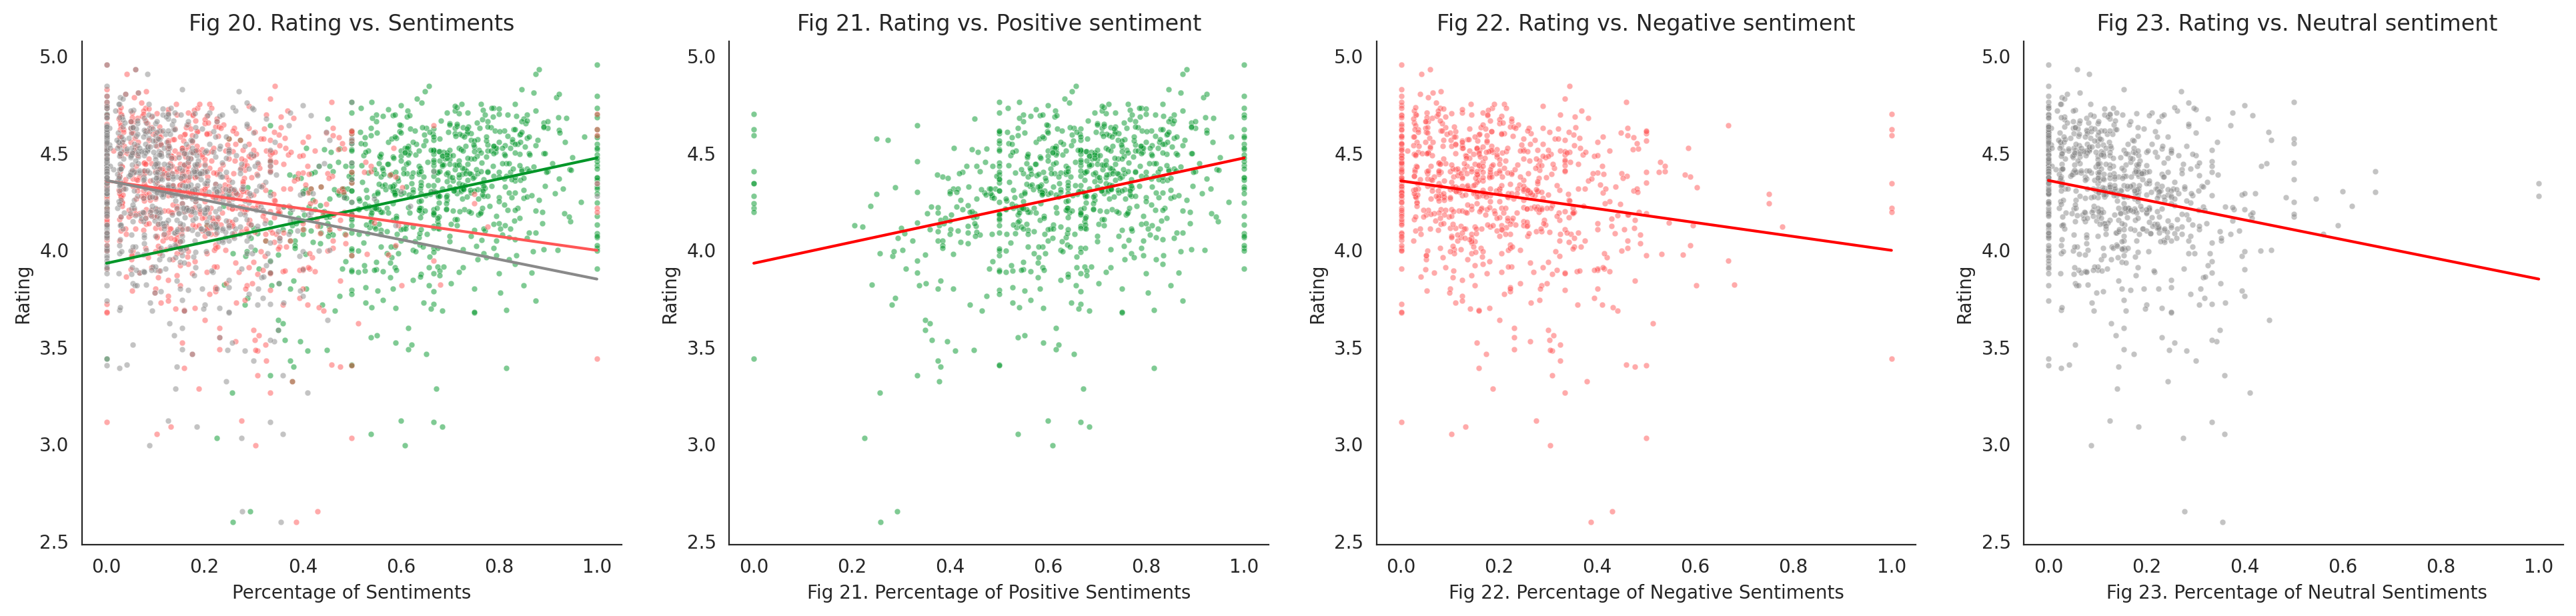

In [53]:
# Add jitter to the rating
rating = app_review['Rating'] + np.random.normal(0, 0.03, size=len(app_review.Rating))

fig, ax_plot = plt.subplots(1,4, figsize=(24,5), dpi=200)

# for each review sentiment type, plot Sentiment vs. Rating
for col, ax, color, name, f in zip(['positive_perc','negative_perc','neutral_perc'], 
                                ax_plot[1:4], 
                                ['#009628','#FF5656', '#898989'], ['Positive','Negative','Neutral'],
                                ['Fig 21.', 'Fig 22.',' Fig 23.']):
  # add regression line of sentiment and rating
  res = linregress(app_review[col], app_review['Rating'])
  fx = np.array([app_review[col].min(), app_review[col].max()])
  fy = res.intercept + res.slope * fx
  # Plot scatterplot of sentiment and rating
  sns.scatterplot(app_review[col], rating, ax=ax, alpha=0.5, s=10, color=color)
  # Add regression line to each plot
  sns.lineplot(fx, fy, ax=ax, color='red')

  ax.set_xlabel(f"{f} Percentage of {name} Sentiments")
  ax.set_title(f"{f} Rating vs. {name} sentiment")
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  # Plot All Rating and Sentiment plots in one
  sns.scatterplot(app_review[col], rating, ax=ax_plot[0], alpha=0.5, s=10, color=color)
  # Add the regression lines
  sns.lineplot(fx, fy, ax=ax_plot[0], color=color)
  
  ax_plot[0].set_xlabel("Percentage of Sentiments")
  ax_plot[0].set_title("Fig 20. Rating vs. Sentiments")
  ax_plot[0].spines['top'].set_visible(False)
  ax_plot[0].spines['right'].set_visible(False)

We can see from the figure above, review sentiments have direct relation to app rating. As the percentage of positive reviews increases, average rating increases. Similarly, negative relationship can be observed from percentage of negative sentiment and app rating. 

In [133]:
# a function that concatenates the reviews by groups
def review_agg(df, new_df):

  """
  Takes a dataframe and an empty dataframe and concatinates reviews for each category and sentiment.

  Input:
  df - a dataframe
  new_df - an empty dataframe

  output:
  new_df - a dataframe with Category, Sentiment and Review as columns
  """

  for cat in ['DATING','ENTERTAINMENT','HOUSE_AND_HOME']:
    for sent in ['Positive','Negative']:
      df_sub = pd.DataFrame.from_dict({'Category':[cat],
                                    'Sentiment':[sent],
                                    'Review': [" ".join(df[(df.Category == cat) & (df.Sentiment == sent)].Translated_Review)]})
      new_df = pd.concat([new_df, df_sub], axis=0)
  
  return new_df

In [134]:
# Merge app_review with review to get the review texts
app_review = pd.merge(app_review, review, on='App', how='right')
# Merge the reviews
cat_reviews = review_agg(app_review[['Category','Sentiment','Translated_Review']], pd.DataFrame()).dropna()
cat_reviews = cat_reviews.set_index(np.arange(0, len(cat_reviews))).pivot('Category','Sentiment','Review')

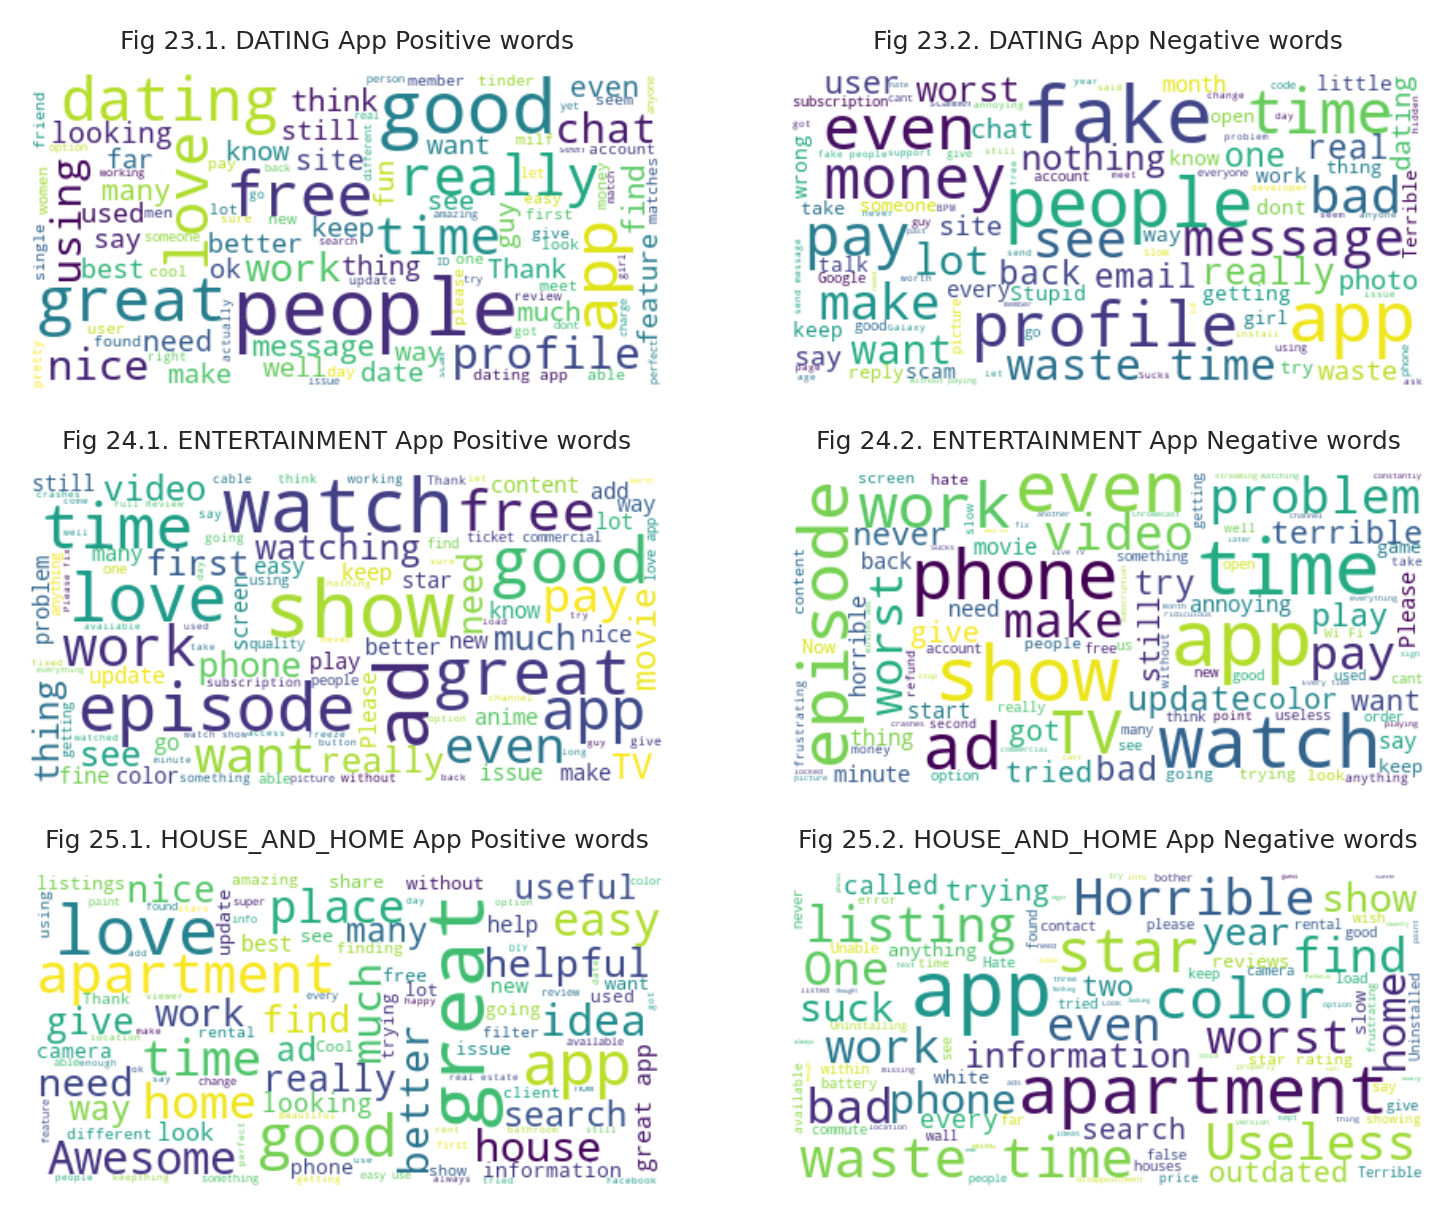

In [136]:
fig, axplots = plt.subplots(3,2, dpi=300, figsize=(6,5))
# for each category of reviews, plot the wordcloud
for row, ax, f in zip(cat_reviews.iterrows(), axplots, np.arange(23, 30)):
  row_values = row[1]
  # Create wordcloud object for positive reviews
  wc0 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(row_values.Positive)
  # Show the image for the positive reviews
  ax[0].imshow(wc0, interpolation='bilinear')
  ax[0].axis('off')
  ax[0].set_title(f"Fig {f}.1. {row[0]} App Positive words", fontsize=6)
  # Create wordcloud object for negative reviews
  wc1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(row_values.Negative)
  # Show the image for the negative reviews
  ax[1].imshow(wc1, interpolation='bilinear')
  ax[1].axis('off')
  ax[1].set_title(f"Fig {f}.2. {row[0]} App Negative words", fontsize=6)

The End of the notebook